#Part 1: Regression — California Housing

**Setup & Load Dataset (with safe fallback)**

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_california_housing, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def load_california_housing_safely():
    try:
        X, y = fetch_california_housing(return_X_y=True)
        cols = ['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']
        df = pd.DataFrame(X, columns=cols)
        df.rename(columns={'MedInc':'median_income',
                           'HouseAge':'housing_median_age',
                           'Population':'population'}, inplace=True)
        df['MedHouseVal'] = y
        return df
    except Exception:
        print('fetch_california_housing failed, trying OpenML...')
        try:
            X, y = fetch_openml(name='california_housing', version=1, as_frame=True, return_X_y=True)
            df = X.copy()
            df['MedHouseVal'] = y
            df['AveRooms']  = df['total_rooms'] / df['households']
            df['AveBedrms'] = df['total_bedrooms'] / df['households']
            df['AveOccup']  = df['population'] / df['households']
            df = df[['median_income','housing_median_age','AveRooms','AveBedrms',
                     'population','AveOccup','latitude','longitude','MedHouseVal']]
            df.dropna(inplace=True)
            return df
        except Exception:
            raise RuntimeError('California Housing could not be loaded. Use Colab or a networked environment.')

cal_df = load_california_housing_safely()
cal_df.head()


fetch_california_housing failed, trying OpenML...


,median_income,housing_median_age,AveRooms,AveBedrms,population,AveOccup,latitude,longitude,MedHouseVal
0,8.3252,41,6.984127,1.023810,322,2.555556,37.88,-122.23,452600
1,8.3014,21,6.238137,0.971880,2401,2.109842,37.86,-122.22,358500
2,7.2574,52,8.288136,1.073446,496,2.802260,37.85,-122.24,352100
3,5.6431,52,5.817352,1.073059,558,2.547945,37.85,-122.25,341300
4,3.8462,52,6.281853,1.081081,565,2.181467,37.85,-122.25,342200


Train–Test Split (80/20)

In [2]:

X = cal_df.drop('MedHouseVal', axis=1)
y = cal_df['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=RANDOM_STATE)
X_train.shape, X_test.shape


((16346, 8), (4087, 8))

#Step 1 — Baseline Linear Regression (no regularization)

**We standardize features to make scales comparable, then fit LinearRegression. We inspect coefficients and compute MSE on train/test.**

In [5]:

linreg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
linreg_pipe.fit(X_train, y_train)

feature_names = X_train.columns
coefs = linreg_pipe.named_steps['model'].coef_
intercept = linreg_pipe.named_steps['model'].intercept_

y_pred_train = linreg_pipe.predict(X_train)
y_pred_test  = linreg_pipe.predict(X_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test  = mean_squared_error(y_test,  y_pred_test)

print('Baseline Linear Regression (standardized features)')
print('Intercept:', intercept)
for fn, c in zip(feature_names, coefs):
    print(f'{fn}: {c:.4f}')
print(f'MSE - Train: {mse_train:.4f} | Test: {mse_test:.4f}')



Baseline Linear Regression (standardized features)
Intercept: 206644.4000978828
median_income: 84392.6294
housing_median_age: 12052.7428
AveRooms: -28548.9838
AveBedrms: 33378.2490
population: -587.6190
AveOccup: -4008.4764
latitude: -89779.4727
longitude: -86741.1724
MSE - Train: 5162710048.3311 | Test: 5645922500.0776


#Step 2 — Hyperparameter tuning for Ridge & Lasso (alpha)

**We use GridSearchCV (5-fold CV) across a log-spaced grid of alpha to find the best regularization strength.
Scoring uses negative MSE (higher is better), so we plot MSE vs alpha.**

Best Ridge alpha: {'model__alpha': np.float64(8.531678524172806)}
Best Lasso alpha: {'model__alpha': np.float64(239.5026619987486)}
Ridge Test MSE: 5643254021.8883
Lasso Test MSE: 5617891286.4785


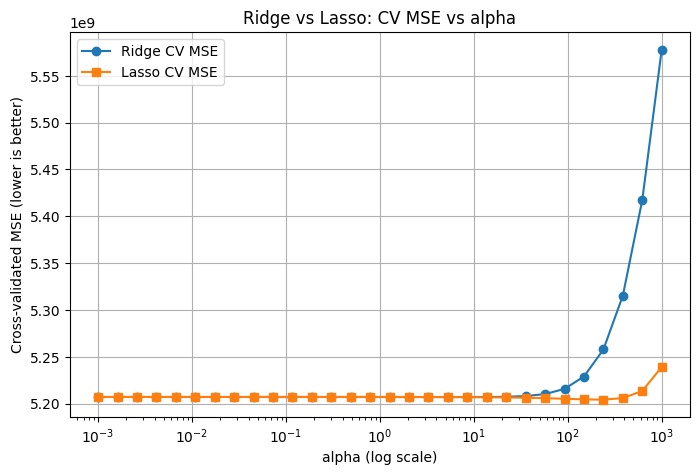

In [6]:

from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-3, 3, 30)

ridge_pipe = Pipeline([('scaler', StandardScaler()), ('model', Ridge(random_state=RANDOM_STATE))])
lasso_pipe = Pipeline([('scaler', StandardScaler()), ('model', Lasso(random_state=RANDOM_STATE, max_iter=10000))])

ridge_grid = GridSearchCV(ridge_pipe, param_grid={'model__alpha': alphas},
                          cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid = GridSearchCV(lasso_pipe, param_grid={'model__alpha': alphas},
                          cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

ridge_grid.fit(X_train, y_train)
lasso_grid.fit(X_train, y_train)

print('Best Ridge alpha:', ridge_grid.best_params_)
print('Best Lasso alpha:', lasso_grid.best_params_)

ridge_best = ridge_grid.best_estimator_
lasso_best = lasso_grid.best_estimator_

ridge_test_mse = mean_squared_error(y_test, ridge_best.predict(X_test))
lasso_test_mse = mean_squared_error(y_test, lasso_best.predict(X_test))
print(f'Ridge Test MSE: {ridge_test_mse:.4f}')
print(f'Lasso Test MSE: {lasso_test_mse:.4f}')

plt.figure(figsize=(8,5))
plt.plot(alphas, -ridge_grid.cv_results_['mean_test_score'], label='Ridge CV MSE', marker='o')
plt.plot(alphas, -lasso_grid.cv_results_['mean_test_score'], label='Lasso CV MSE', marker='s')
plt.xscale('log')
plt.xlabel('alpha (log scale)')
plt.ylabel('Cross-validated MSE (lower is better)')
plt.title('Ridge vs Lasso: CV MSE vs alpha')
plt.legend()
plt.grid(True)
plt.show()


#Step 3 — Regularization experiments (L1 vs L2)

**Compare coefficients and MSE on train & test.
L1 (Lasso) often yields sparse coefficients (some zeros), while L2 (Ridge) shrinks values but rarely zeros them.**

Ridge coefficients:
median_income: 84350.6657
housing_median_age: 12120.1455
AveRooms: -28390.3339
AveBedrms: 33174.6685
population: -563.0737
AveOccup: -4012.2209
latitude: -89124.1224
longitude: -86078.5783

Lasso coefficients:
median_income: 83173.4584
housing_median_age: 12244.9403
AveRooms: -25498.0214
AveBedrms: 30306.8446
population: -278.2374
AveOccup: -3786.5738
latitude: -87099.0326
longitude: -83917.5117

Number of (near) zero coefficients in Lasso: 0
Ridge MSE — Train: 5162777599.2500 | Test: 5643254021.8883
Lasso MSE — Train: 5165869602.3411 | Test: 5617891286.4785


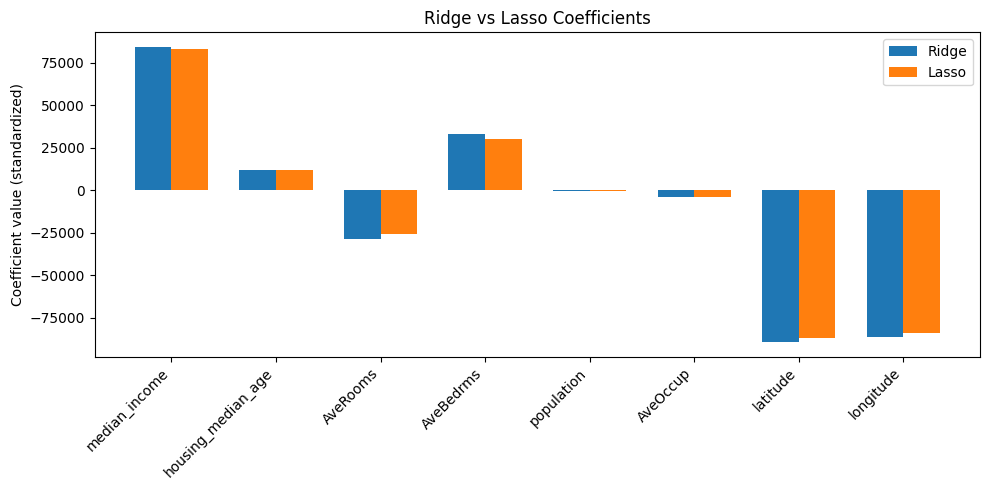

In [7]:

ridge_coefs = ridge_best.named_steps['model'].coef_
lasso_coefs = lasso_best.named_steps['model'].coef_

ridge_train_mse = mean_squared_error(y_train, ridge_best.predict(X_train))
lasso_train_mse = mean_squared_error(y_train, lasso_best.predict(X_train))
ridge_test_mse  = mean_squared_error(y_test,  ridge_best.predict(X_test))
lasso_test_mse  = mean_squared_error(y_test,  lasso_best.predict(X_test))

print('Ridge coefficients:')
for fn, c in zip(feature_names, ridge_coefs):
    print(f'{fn}: {c:.4f}')

print('\nLasso coefficients:')
zero_count = 0
for fn, c in zip(feature_names, lasso_coefs):
    print(f'{fn}: {c:.4f}')
    if abs(c) < 1e-8:
        zero_count += 1
print(f'\nNumber of (near) zero coefficients in Lasso: {zero_count}')

print(f'Ridge MSE — Train: {ridge_train_mse:.4f} | Test: {ridge_test_mse:.4f}')
print(f'Lasso MSE — Train: {lasso_train_mse:.4f} | Test: {lasso_test_mse:.4f}')

# Visualize coefficients side-by-side
x = np.arange(len(feature_names))
width = 0.35
plt.figure(figsize=(10,5))
plt.bar(x - width/2, ridge_coefs, width, label='Ridge')
plt.bar(x + width/2, lasso_coefs, width, label='Lasso')
plt.xticks(x, feature_names, rotation=45, ha='right')
plt.ylabel('Coefficient value (standardized)')
plt.title('Ridge vs Lasso Coefficients')
plt.legend()
plt.tight_layout()
plt.show()


**Bias–Variance takeaway:**

Regularization (L1/L2) reduces variance, helping prevent overfitting.
L1 performs feature selection by zeroing some coefficients; L2 shrinks all, stabilizing estimates.
If alpha is too large, bias increases → underfitting (train & test errors rise).
Choose alpha using CV curves that balance the trade-off.

#part 2: Classification — Breast Cancer

**Load & Split (80/20, stratified)**

In [8]:

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_bc, y_bc = load_breast_cancer(return_X_y=True)
X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(
    X_bc, y_bc, test_size=0.2, random_state=RANDOM_STATE, stratify=y_bc)
X_train_bc.shape, X_test_bc.shape


((455, 30), (114, 30))

# Step 1 — Baseline Logistic Regression (default settings)

**Default LogisticRegression uses L2 penalty (with lbfgs solver). We standardize features, fit, view coefficients, and report accuracy.**

Baseline Logistic Regression (L2, standardized)
Intercept: [0.30220757]
Train accuracy: 0.989010989010989
Test accuracy: 0.9824561403508771


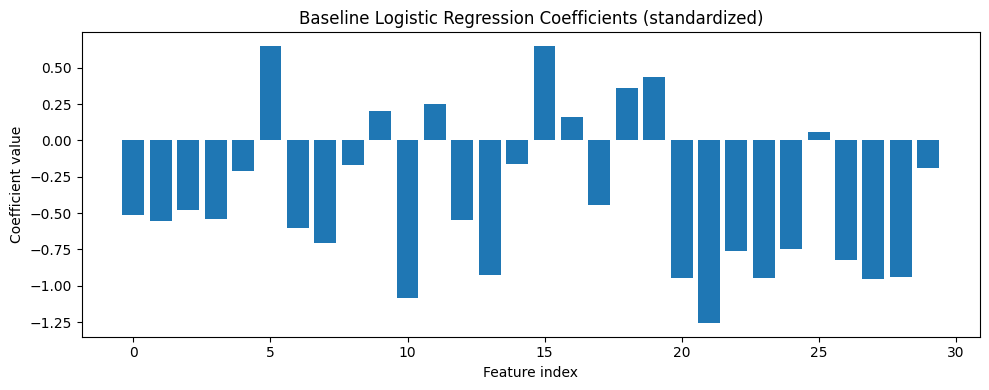

In [9]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

logreg_base = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])
logreg_base.fit(X_train_bc, y_train_bc)

coef = logreg_base.named_steps['model'].coef_.ravel()
intercept = logreg_base.named_steps['model'].intercept_

y_pred_train = logreg_base.predict(X_train_bc)
y_pred_test  = logreg_base.predict(X_test_bc)
acc_train = accuracy_score(y_train_bc, y_pred_train)
acc_test  = accuracy_score(y_test_bc,  y_pred_test)

print('Baseline Logistic Regression (L2, standardized)')
print('Intercept:', intercept)
print('Train accuracy:', acc_train)
print('Test accuracy:', acc_test)

plt.figure(figsize=(10,4))
plt.bar(np.arange(len(coef)), coef)
plt.title('Baseline Logistic Regression Coefficients (standardized)')
plt.xlabel('Feature index')
plt.ylabel('Coefficient value')
plt.tight_layout()
plt.show()


#Step 2 — Tune C and penalty via GridSearchCV

**Use solver='liblinear' (supports both l1 and l2 for binary classification), grid over C and penalty.**

Best params: {'model__C': 0.1, 'model__penalty': 'l2'}
Best model test accuracy: 0.9824561403508771


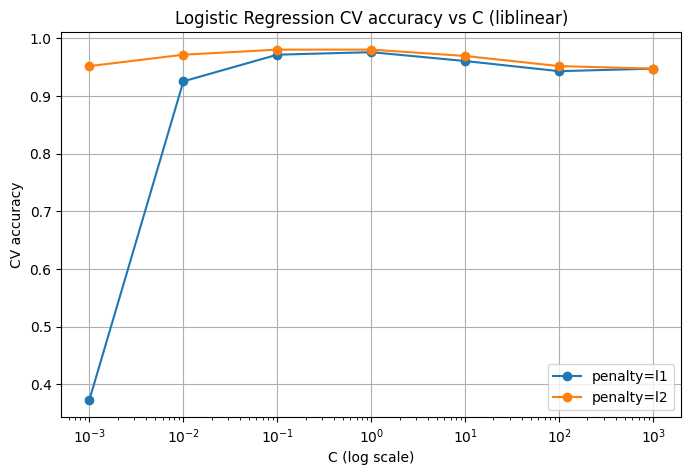

In [10]:

logreg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(solver='liblinear', max_iter=1000, random_state=RANDOM_STATE))
])
param_grid = {
    'model__C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
    'model__penalty': ['l1', 'l2']
}
grid = GridSearchCV(logreg_pipe, param_grid=param_grid, cv=5,
                    scoring='accuracy', n_jobs=-1)
grid.fit(X_train_bc, y_train_bc)
print('Best params:', grid.best_params_)
best_logreg = grid.best_estimator_
acc_test_best = accuracy_score(y_test_bc, best_logreg.predict(X_test_bc))
print('Best model test accuracy:', acc_test_best)

# Plot CV accuracy vs C for L1/L2
results = pd.DataFrame(grid.cv_results_)
plt.figure(figsize=(8,5))
for pen in ['l1','l2']:
    mask = results['param_model__penalty'] == pen
    Cs = results.loc[mask, 'param_model__C'].astype(float)
    acc = results.loc[mask, 'mean_test_score']
    plt.plot(Cs, acc, marker='o', label=f'penalty={pen}')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('CV accuracy')
plt.title('Logistic Regression CV accuracy vs C (liblinear)')
plt.legend()
plt.grid(True)
plt.show()


#Step 3 — L1 vs L2 (train with best C for each), compare coefficients & accuracy

****

L1 — Train acc: 0.9890 | Test acc: 0.9912
L2 — Train acc: 0.9868 | Test acc: 0.9825
Number of zero coefficients — L1: 14, L2: 0


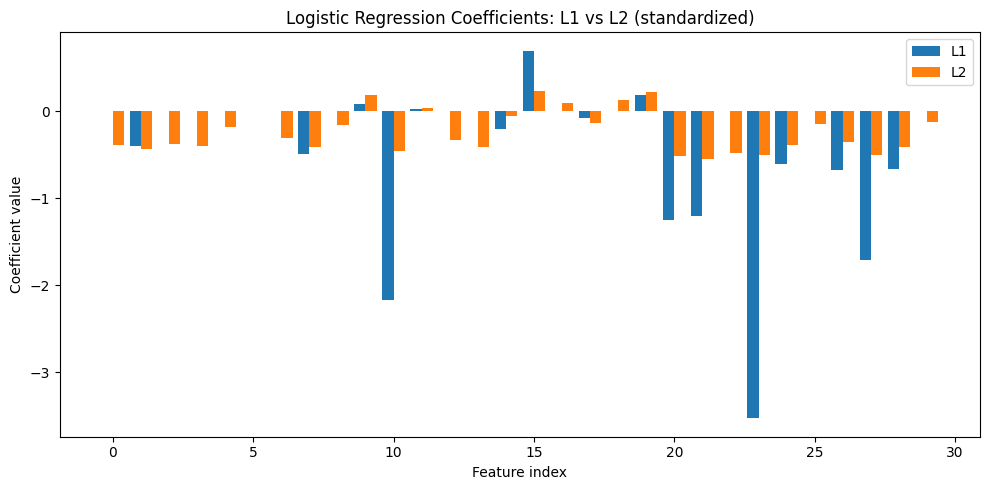

In [11]:

res = pd.DataFrame(grid.cv_results_)
best_Cs = {}
for pen in ['l1','l2']:
    sub = res[res['param_model__penalty'] == pen]
    row = sub.iloc[sub['mean_test_score'].argmax()]
    best_Cs[pen] = float(row['param_model__C'])

logreg_l1 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(solver='liblinear', penalty='l1',
                                C=best_Cs['l1'], max_iter=1000, random_state=RANDOM_STATE))
])
logreg_l2 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(solver='liblinear', penalty='l2',
                                C=best_Cs['l2'], max_iter=1000, random_state=RANDOM_STATE))
])

logreg_l1.fit(X_train_bc, y_train_bc)
logreg_l2.fit(X_train_bc, y_train_bc)

coef_l1 = logreg_l1.named_steps['model'].coef_.ravel()
coef_l2 = logreg_l2.named_steps['model'].coef_.ravel()

acc_train_l1 = accuracy_score(y_train_bc, logreg_l1.predict(X_train_bc))
acc_test_l1  = accuracy_score(y_test_bc,  logreg_l1.predict(X_test_bc))
acc_train_l2 = accuracy_score(y_train_bc, logreg_l2.predict(X_train_bc))
acc_test_l2  = accuracy_score(y_test_bc,  logreg_l2.predict(X_test_bc))

print(f'L1 — Train acc: {acc_train_l1:.4f} | Test acc: {acc_test_l1:.4f}')
print(f'L2 — Train acc: {acc_train_l2:.4f} | Test acc: {acc_test_l2:.4f}')

zero_count_l1 = int(np.sum(np.isclose(coef_l1, 0.0)))
zero_count_l2 = int(np.sum(np.isclose(coef_l2, 0.0)))
print(f'Number of zero coefficients — L1: {zero_count_l1}, L2: {zero_count_l2}')

# Visualize
idx = np.arange(len(coef_l1))
plt.figure(figsize=(10,5))
plt.bar(idx - 0.2, coef_l1, width=0.4, label='L1')
plt.bar(idx + 0.2, coef_l2, width=0.4, label='L2')
plt.title('Logistic Regression Coefficients: L1 vs L2 (standardized)')
plt.xlabel('Feature index')
plt.ylabel('Coefficient value')
plt.legend()
plt.tight_layout()
plt.show()
